In [1]:
import os

os.chdir('C:/Users/howar/Desktop/Coursework/ME4-Individual-Project-Volatility-Forecasting/data')

# Daily returns and summary statistics

In [2]:
import pandas as pd
import numpy as np

In [3]:
r = pd.read_csv('daily_returns.csv', index_col=0, parse_dates=True)
sentiment = pd.read_csv('sentiment_features.csv', index_col=0, parse_dates=True)

# Not using sentiment but need to match dates
sentiment = sentiment[sentiment.index.isin(r.index)]
r = r[r.index.isin(sentiment.index)]

In [4]:
print('Period: {} to {}'.format(r.index.date[0], r.index.date[-1]))
print('No. of samples:', len(r))

Period: 2013-01-02 to 2021-12-31
No. of samples: 2266


In [5]:
r.describe()

,XLE,XLB,XLI,XLY,XLP,XLV,XLF,XLK,XLU
count,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000
mean,0.000035,0.000469,0.000529,0.000695,0.000455,0.000621,0.000549,0.000852,0.000452
std,0.017919,0.012762,0.012109,0.011316,0.008963,0.010587,0.013652,0.012995,0.011599
min,-0.225499,-0.161343,-0.120506,-0.133937,-0.098284,-0.103107,-0.149252,-0.148192,-0.120863
25%,-0.007630,-0.005464,-0.004556,-0.004175,-0.003408,-0.004068,-0.005052,-0.004106,-0.004880
50%,0.000196,0.000906,0.000945,0.001400,0.000609,0.000938,0.000953,0.001148,0.001143
75%,0.008163,0.006921,0.006144,0.006500,0.004825,0.006032,0.006842,0.006869,0.006157
max,0.152327,0.112283,0.120927,0.091663,0.080626,0.073352,0.124412,0.111023,0.122076


It is important to see if the time series' are stationary. The weak form of stationarity is that the first two moments (mean and variance) are time-invariant.

In [7]:
from statsmodels.tsa.stattools import adfuller

# Null hypothesis of Augmented Dicket-Fuller is that there is a unit root.
# Reject of null hypothesis implies stationarity.
tickers = r.columns

all_stationary = True

for t in tickers:
    results = adfuller(r[t])
    if results[1] > 0.05:
        all_stationary = False
        break

all_stationary

True

# Fitting ARMA GARCH

First we see if the returns are autocorrelated. We use XLK as an example.

C:\Users\howar\Anaconda3\envs\fyp\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


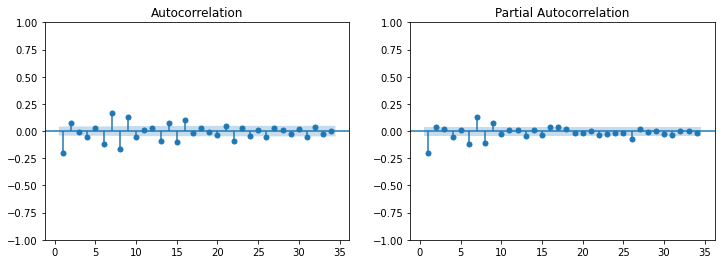

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

xlk = r['XLK']
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(xlk, zero=False, ax=ax[0])
plot_pacf(xlk, zero=False, ax=ax[1])
plt.show()

The autocorrelation and partial-autocorrelation are most-significant at lag = 1. This suggests that $r$ can be described as an AR(1)-GARCH(1, 1) process.

In [11]:
from arch.univariate import arch_model

model = arch_model(xlk.values, mean='ARX', lags=1, vol='GARCH', p=1, q=1, dist='normal', rescale=True)
x = model.fit(disp=False)
x

                           AR - GARCH Model Results                           
Dep. Variable:                      y   R-squared:                       0.021
Mean Model:                        AR   Adj. R-squared:                  0.021
Vol Model:                      GARCH   Log-Likelihood:               -3223.15
Distribution:                  Normal   AIC:                           6456.30
Method:            Maximum Likelihood   BIC:                           6484.93
                                        No. Observations:                 2265
Date:                Fri, Jan 21 2022   Df Residuals:                     2263
Time:                        11:25:55   Df Model:                            2
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.1058  1.977e-02      5.353  8.659e-08 [6.709e-0

All coefficients are significant. Let's look at the residuals of the fit. They should be a white noise process:

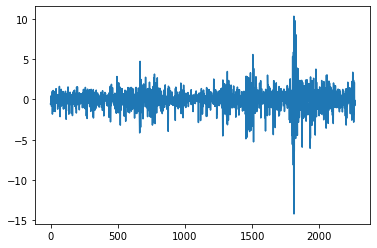

In [12]:
residuals = x.resid[1:]
plt.plot(residuals)

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(residuals, lags=[10])  # White noise

,lb_stat,lb_pvalue
10,228.186209,2.061480e-43
